# Connecting to MySQL from Python

In [1]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd

In [2]:
# Get the password without it being visible
import getpass

In [3]:
password = getpass.getpass()

········


In [4]:
# Define a connection string
# Dialect + driver :// username : password @host(domain) : database name

connection_string = "mysql+pymysql://root:" + password + "@localhost/bank"
engine = create_engine(connection_string)

# Initial query on loans to check everything works

In [5]:
# Dataframe creation
df = pd.read_sql_query("SELECT * FROM loan", engine)
df

,loan_id,account_id,date,amount,duration,payments,status
0,5314,1787,930705,96396,12,8033.0,B
1,5316,1801,930711,165960,36,4610.0,A
2,6863,9188,930728,127080,60,2118.0,A
3,5325,1843,930803,105804,36,2939.0,A
4,7240,11013,930906,274740,60,4579.0,A
...,...,...,...,...,...,...,...
677,4989,105,981205,352704,48,7348.0,C
678,5221,1284,981205,52512,12,4376.0,C
679,6402,6922,981206,139488,24,5812.0,C
680,5346,1928,981206,55632,24,2318.0,C


# Aggregated query to select summary rows of loans

In [6]:
dloans = pd.read_sql_query("""
SELECT
    d.A2 AS district, 
    SUM(l.amount) AS total_borrowed, 
    ROUND(AVG(l.amount)) AS avg_loan, 
    COUNT(l.loan_id) AS no_loans
FROM loan l 
JOIN account a USING(account_id) 
JOIN district d 
ON a.district_id= d.A1 
GROUP BY 1
ORDER BY 3 DESC 
LIMIT 20;""", engine)

In [7]:
dloans.head()

,district,total_borrowed,avg_loan,no_loans
0,Nachod,1768380.0,294730.0,6
1,Ceske Budejovice,2010924.0,251366.0,8
2,Beroun,1460796.0,243466.0,6
3,Jesenik,1938432.0,242304.0,8
4,Kutna Hora,2095980.0,232887.0,9


In [8]:
dloans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   district        20 non-null     object 
 1   total_borrowed  20 non-null     float64
 2   avg_loan        20 non-null     float64
 3   no_loans        20 non-null     int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 768.0+ bytes


# Visualization

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Defining the question
# Right chart type / aggregate to answer the question

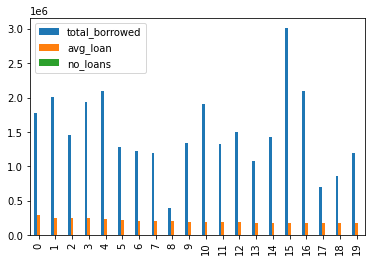

In [10]:
plotdata = dloans
plotdata.plot(kind = "bar")

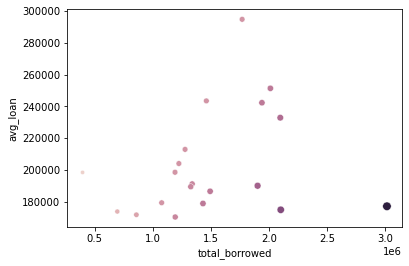

In [11]:
# Q: What's the relation between the no_of_loans, size of loans per district?
sns.scatterplot(x = "total_borrowed", y = "avg_loan",
                hue = "no_loans", size = "no_loans", legend = 0, data = dloans)

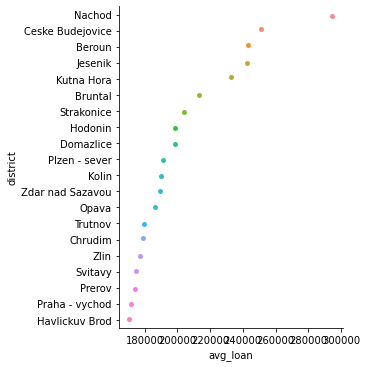

In [12]:
sns.catplot(y = "district", x = "avg_loan", data = dloans)

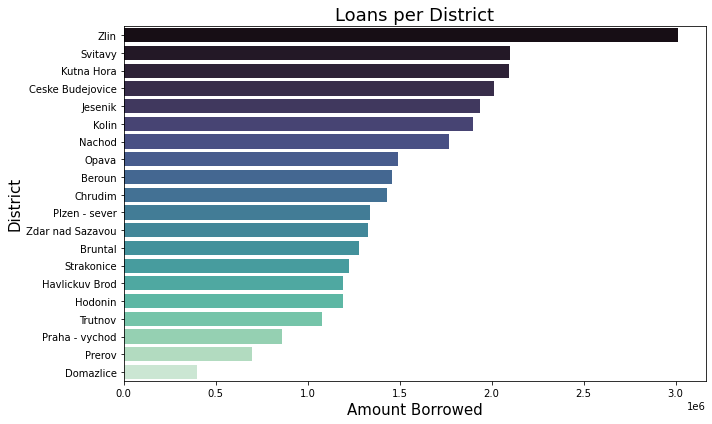

In [13]:
# Q: In which district have we lent the most?
plt.figure(figsize=(10,6))
sns_plot = sns.barplot(y = "district", x = "total_borrowed", data = dloans, palette = "mako", order = dloans.sort_values("total_borrowed", ascending = False).district)

# Set labels
plt.xlabel("Amount Borrowed", size=15)
plt.ylabel("District", size=15)
plt.title("Loans per District", size=18)
plt.tight_layout()

# Export image 
plt.savefig("loans_district.png", dpi=100)

In [14]:
dloans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   district        20 non-null     object 
 1   total_borrowed  20 non-null     float64
 2   avg_loan        20 non-null     float64
 3   no_loans        20 non-null     int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 768.0+ bytes


# Can we do a churn analysis without a complex SQL query?

In [15]:
# Note: We dont want to just join trans to loans and pull back all the data as the trans table is very big.
# We need the join anyway as it's unavoidable.

statuses = pd.read_sql_query("""
SELECT
    l.status, 
    t.date,
    COUNT(DISTINCT t.account_id) AS no_of_accounts,
    COUNT(DISTINCT t.trans_id) as no_of_trans,
    SUM(t.amount) AS moved_amount 
FROM trans t
JOIN disp d USING(account_id) 
JOIN loan l USING(account_id) 
WHERE d.type = 'OWNER'
GROUP BY l.status, t.date""", engine)

In [16]:
statuses.head()

,status,date,no_of_accounts,no_of_trans,moved_amount
0,A,930114,2,2,45749.0
1,A,930117,1,1,1100.0
2,A,930119,1,1,700.0
3,A,930124,1,1,900.0
4,A,930125,1,1,900.0


In [17]:
statuses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7615 entries, 0 to 7614
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   status          7615 non-null   object 
 1   date            7615 non-null   int64  
 2   no_of_accounts  7615 non-null   int64  
 3   no_of_trans     7615 non-null   int64  
 4   moved_amount    7615 non-null   float64
dtypes: float64(1), int64(3), object(1)
memory usage: 297.6+ KB


In [18]:
# Extract to csv to visualize in Tableau
statuses.to_csv("statuses.csv", index=False)

In [19]:
# Extract month and year from date field
statuses['date'] = statuses['date'].astype(str)
statuses['M-Y'] = statuses[str('date')].str[:4]

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

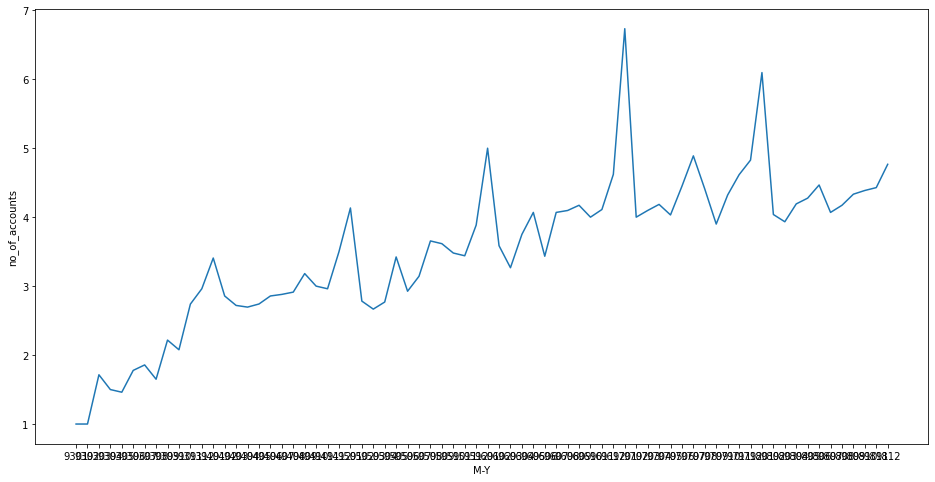

In [21]:
b_status = statuses.query("status == 'B'")
fig = plt.figure(figsize = (16, 8))
sns.lineplot(data = b_status, x = "M-Y", y = "no_of_accounts", ci = None)

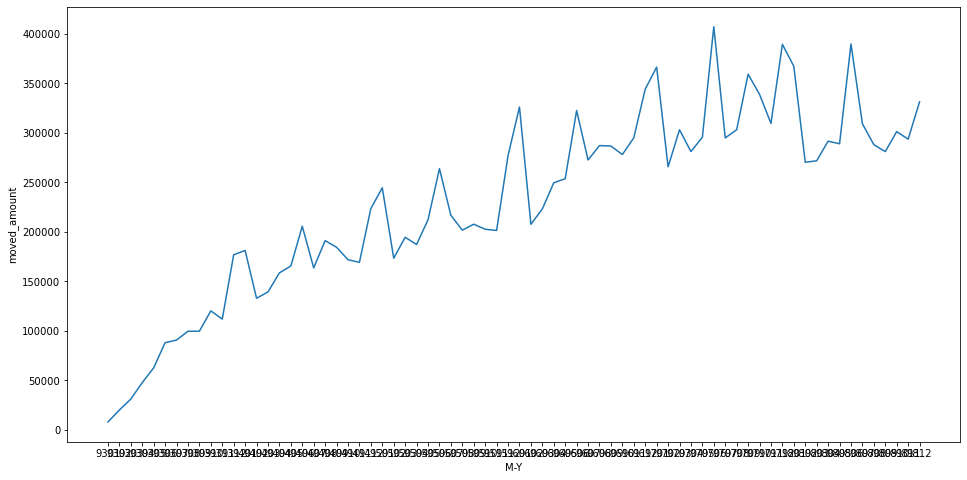

In [22]:
b_status = statuses.query("status == 'A'")
fig = plt.figure(figsize=(16, 8))
sns.lineplot(data = b_status, x = "M-Y", y = "moved_amount", ci = None)

In [23]:
# Group the loan statuses - create function
def statusgroup(x):
    if x in ("B", "D"):
        return "bad_loans"
    else:
        return "good_loans"

In [24]:
# Apply this to a new column using list map
statuses["status_group"] = list(map(statusgroup, statuses["status"]))

In [25]:
# Create a group by dataframe
grouped = statuses.groupby(["M-Y", "status_group"])["no_of_trans"].sum()
grouped.head(10)

M-Y   status_group
9301  bad_loans         3
      good_loans       10
9302  bad_loans         3
      good_loans       42
9303  bad_loans        13
      good_loans       86
9304  bad_loans        18
      good_loans      127
9305  bad_loans        27
      good_loans      182
Name: no_of_trans, dtype: int64

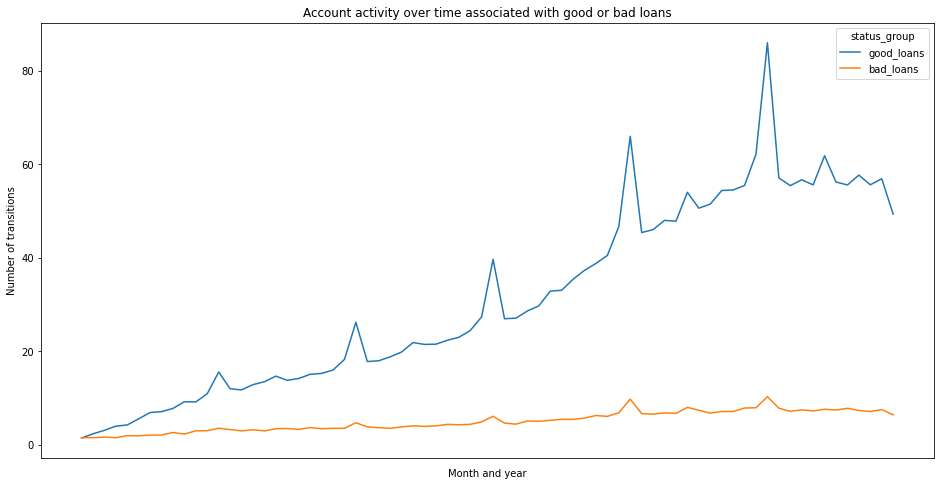

In [26]:
fig = plt.figure(figsize = (16, 8))
g = sns.lineplot(data = statuses, x = "M-Y", y = "no_of_trans", hue = "status_group", ci= None)
g.set(xticklabels = [])
g.set(xlabel = "Month and year")
g.set(ylabel = "Number of transitions")
g.set(title = "Account activity over time associated with good or bad loans")
g.tick_params(bottom = False)
plt.show()